In [1]:
using Revise
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter
using CSV
using DataFrames


In [2]:
import ReactiveMP.messageout

In [3]:
include("../helpers/polynomial.jl")

ϕ (generic function with 2 methods)

In [24]:
### find order
delay_y, delay_u, delay_e = 3, 3, 3
poly_order = 2
order_h = delay_e + 1

output__ = ϕ(randn(sum([delay_y, delay_u, order_h])), Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false))
full_order = length(output__)

42

In [5]:

function phi()
    options = Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false)
    
    precompiled = precompiled_phi(options)
    
    return (y, u, h) -> begin
        na = length(y)
        nb = length(u)-1
        ne = length(h)-1
        precompiled([y; u; h[2:end]])
    end 
end

const phi_ = phi()

#3 (generic function with 1 method)

In [43]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function narmax(n, h_prior, w_prior, η_prior, τ_prior, y_prev, u, h_order, full_order, seed)
    obs_prec = 1e12  # softening plus
    
    # initialize variables
    θ  = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(h_order), obs_prec*diageye(h_order)))}
    w  = randomvar()
#     h  = randomvar(n) where { prod_constraint = ProdGeneric(), form_constraint = SampleListFormConstraint(nsamples, LeftProposal())}
#     z  = randomvar(n) where { prod_constraint = ProdGeneric(), form_constraint = SampleListFormConstraint(nsamples, RightProposal())}
    h  = randomvar(n)
    z  = randomvar(n)
    ẑ  = randomvar(n)
    y  = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    
    AR_meta_1 = ARMeta(Multivariate, h_order, ARsafe())
    AR_meta_2 = ARMeta(Multivariate, full_order, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2]) where {q=MeanField()}
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(h_order), diageye(h_order))
    
    η   ~ MvNormalMeanPrecision(η_prior[1], η_prior[2])
    τ   ~ GammaShapeRate(τ_prior[1], τ_prior[2])
    
    b = zeros(full_order); b[1] = 1.0;
    c = zeros(h_order); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
        
        h[t] ~ AR(h_prev, θ, w) where {q = q(y,x)q(γ)q(θ), meta = AR_meta_1}
        z[t] ~ NonlinearNode(h[t]) where {pipeline=RequireInbound(in=MvNormalMeanPrecision(zeros(h_order), diageye(h_order))), meta = NonlinearMeta(phi_, y_prev[t], u[t], seed)}
        ẑ[t] ~ AR(z[t], η, τ) where {q = q(y,x)q(γ)q(θ), meta = AR_meta_2}
        
#         y_nodes[t], y[t] ~ NormalMeanPrecision(dot(ẑ[t], b) + dot(h[t], c), obs_prec)
        y_nodes[t], y[t] ~ dot(ẑ[t], b) + dot(h[t], c)
        
        h_prev = h[t]
    end

    return θ, w, h, η, τ, z, ẑ, y_nodes, y
end

┌ Warning: `form_constraint` option is deprecated. Use `marginal_form_constraint` option for variable θ instead.
└ @ GraphPPL /Users/apodusenko/.julia/dev/GraphPPL/src/backends/reactivemp.jl:270


In [44]:
function narmax_inference(observations, observations_prev, controls; 
                          h_order, full_order,
                          h_prior=(randn(h_order), diageye(h_order)),
                          w_prior=(1.0, 1.0), 
                          η_prior=(zeros(full_order), diageye(full_order)),
                          τ_prior=(1.0, 1.0), vmp_its=10, seed=10, 
                          progress=true)
        
    n = length(observations)

    # define model
    model, (θ, w, h, η, τ, z, ẑ, y_nodes, y) = narmax(model_options(limit_stack_depth = 500),
                                                      n, h_prior, w_prior, η_prior, τ_prior, 
                                                      observations_prev, controls, h_order, full_order, seed)
    
    h_buffer = Vector{Marginal}(undef, n)
    z_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    θ_buffer = nothing
    w_buffer = nothing
    η_buffer = nothing
    τ_buffer = nothing
    
    subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    subscribe!(getmarginals(z), (x) -> copyto!(z_buffer, x))
    
    subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    subscribe!(getmarginal(η), (x) -> η_buffer = x)
    subscribe!(getmarginal(w), (x) -> w_buffer = x)
    subscribe!(getmarginal(τ), (x) -> τ_buffer = x)

    subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginals!(h, MvNormalMeanPrecision(randn(h_order), diageye(h_order)))
    setmarginals!(z, MvNormalMeanPrecision(randn(full_order), diageye(full_order)))
    setmarginal!(w, GammaShapeRate(w_prior[1], w_prior[2]))
    setmarginal!(θ, MvNormalMeanPrecision(randn(h_order), diageye(h_order)))
    setmarginal!(τ, GammaShapeRate(τ_prior[1], τ_prior[2]))
    setmarginal!(η, MvNormalMeanPrecision(η_prior[1], η_prior[2]))
    
    setmessages!(h, MvNormalMeanPrecision(zeros(h_order), diageye(h_order)))
    
    p = ProgressMeter.Progress(vmp_its)
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
        if progress
            ProgressMeter.next!(p)
        end
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, θ_buffer, w_buffer, η_buffer, τ_buffer, z_buffer, y_out_buffer
    
end

narmax_inference (generic function with 1 method)

In [45]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

## cascade dataset

In [46]:
df = DataFrame(CSV.File("../datasets/cascadedtanks/dataBenchmark.csv"));
u_train, u_val, y_train, y_val = df[:,1], df[:,2], df[:,3], df[:,4]

# normalization
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
output_trn = (y_train .- m_y) ./ s_y
output_val = (y_val .- m_y) ./ s_y
input_trn = (u_train .- m_u) ./ s_u
input_val = (u_val .- m_u) ./ s_u;

# output_trn = y_train
# output_val = y_val
# input_trn = input_trn
# input_val = input_val

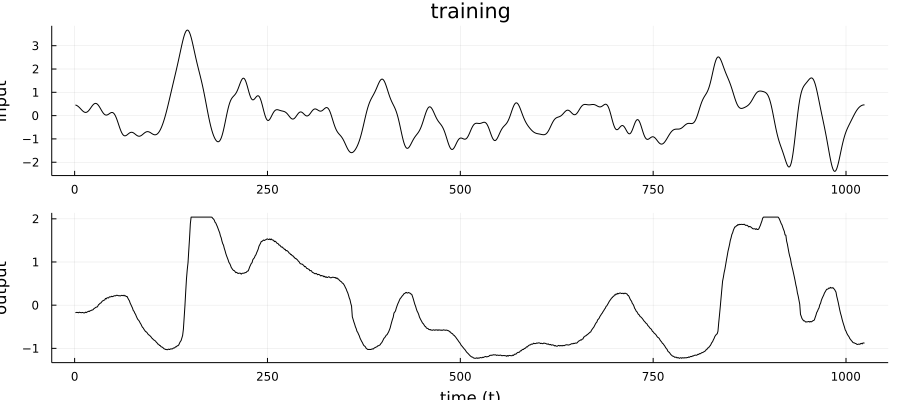

In [47]:
# Plot every n-th time-point to avoid figure size exploding
n = 1
ix = 1:n:length(output_trn)

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

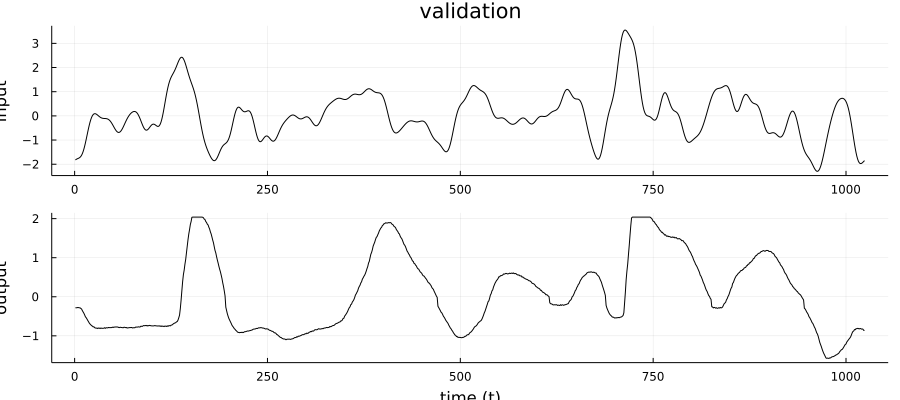

In [48]:
n = 1
ix = 1:n:length(output_val)

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

## silverbox dataset

In [49]:

# df = DataFrame(CSV.File("../datasets/silverbox/SNLS80mV.csv", ignoreemptylines=true))

# # Select input and output signals
# input = df[:,:V1]
# output = df[:,:V2]

# # Time horizon
# T = length(input);

# # normalization
# input = (input .- mean(input))/std(input)
# output = (output .- mean(output))/std(output);

In [50]:
# # Select training set
# trn = collect(40101:131072)
# input_trn = input[trn]
# output_trn = output[trn]
# T_trn = length(trn);

# # Select validation set
# val = 101:40100
# input_val = input[val]
# output_val = output[val]
# T_val = length(val);

In [51]:
# # Plot every n-th time-point to avoid figure size exploding
# n = 100
# ix = 1:n:T_trn

# # Plot training signals
# p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
# p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
# p1 = plot(p1a, p1b, layout=(2,1))

In [52]:
# n = 1
# ix = 1:n:1024

# # Plot validation signals
# p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
# p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
# p1 = plot(p1a, p1b, layout=(2,1))

### prepare training/test sets 

In [53]:
train_size = 1000
test_size = 1000
# train_size = 100
# test_size = 50

# Generate training data
observations_prev, observations = ssm(output_trn, delay_y)
controls = ssm(input_trn, delay_u+1)[1]
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size];

# Generate validation data
observations_prev, observations = ssm(output_val, delay_y)
controls = ssm(input_val, delay_u+1)[1]
X_test, Y_test, U_test = observations_prev[1:test_size], observations[1:test_size], controls[1:test_size];

In [54]:
include("../helpers/ar_extension.jl")

In [55]:
include("../helpers/nonlinear_node.jl")

In [56]:
# @unpack fe_, h_, w_, η_, τ_ = JLD.load("../dump/narmax_inferred_cascade_$(delay_y)_$(delay_u)_$(delay_e)_$(poly_order).jld");
# @unpack fe_, h_, w_, η_, τ_ = JLD.load("../dump/narmax_inferred_silverbox_$(delay_y)_$(delay_u)_$(delay_e)_$(poly_order).jld");

In [57]:
function sr_forward(method::AbstractApproximationMethod, g::Function, m::AbstractVector{T}, P::AbstractMatrix{T}) where { T <: Real }
    ndims = length(m)
    weights = ReactiveMP.getweights(method, m, P)
    points  = ReactiveMP.getpoints(method, m, P)

    mean = zeros(T, length(g(m)))

    for (index, (weight, point)) in enumerate(zip(weights, points))
        gv = weight*g(point)
        mean += gv
    end
#     mean = mean/(2ndims+1)
    

    cov = zeros(T, length(mean), length(mean))
    for (index, (weight, point)) in enumerate(zip(weights, points))
#         g(point)
        dv = (g(point) - mean)
        cov = cov +  weight*(dv)*(dv)'
    end
    
    cor = zeros(T, ndims, length(mean))
    for (index, (weight, point)) in enumerate(zip(weights, points))
        d1  = g(point) - mean
        d2  = point - m
        cor = cor +  weight*(d2)*(d1)'
    end


    return mean, cov, cor
end

# function sr_backwards(method::AbstractApproximationMethod,g,m_in,m_out)
    

    
#     m, P, C = sr_forward(approximation,def_fn,mean(m_in),cov(m_in))
#     S = P + cov(m_out)
#     C = sr_cross_covariance(approximation,def_fn,m_in,m)
   
#     K = C*ReactiveMP.cholinv(S)
    
#     m_update = mean(m_in) + K*(mean(m_out)-m)
#     P_update = cov(m_in) - K*S*K'
# end


# function sr_cross_covariance(method::AbstractApproximationMethod,g,dist,m)
#     mdist, Pdist = mean_cov(dist)
#     ndims1 = length(mdist)
#     ndims2 = length(m)
    
#     weights = ReactiveMP.getweights(method, mdist, Pdist)
#     points  = ReactiveMP.getpoints(method, mdist, Pdist)

#     cor = zeros(ndims1, ndims2)
#     for (index, (weight, point)) in enumerate(zip(weights, points))
#         d1 = g(point) - m
#         d2 = point - mean(dist)
#         cor = cor +  (d2)*(d1)'
#     end
#     cor = cor/(2ndims1+1)


#     return cor 
    
# end


sr_forward (generic function with 1 method)

In [58]:
@rule NonlinearNode(:out, Marginalisation) (m_in::NormalDistributionsFamily, meta::NonlinearMeta) = begin
    def_fn(s) = meta.fn(meta.us, meta.ysprev, s)
    approximation = ReactiveMP.srcubature()
    m, P, _ = sr_forward(approximation,def_fn,mean(m_in),cov(m_in))
    return MvNormalMeanCovariance(m, P)
end

@rule NonlinearNode(:in, Marginalisation) (m_out::NormalDistributionsFamily, m_in::NormalDistributionsFamily, meta::NonlinearMeta) = begin
    def_fn(s) = meta.fn(meta.us, meta.ysprev, s)
    approximation = ReactiveMP.srcubature()
    m, P, C = sr_forward(approximation,def_fn,mean(m_in),cov(m_in))
    S = P + cov(m_out)
   
    K = C*ReactiveMP.cholinv(S)
    
    m_update = mean(m_in) + K*(mean(m_out)-m)
    P_update = cov(m_in) - K*S*K'
    return MvNormalMeanCovariance(m_update, P_update)
end


In [59]:
realish = [0.0001249168565140039, -0.04797386559225805, 0.10644909220635754, 0.14494394608517608, -0.07033359635400402, -0.19548617037008342, -0.19093363531995966, -0.025089384031466766, -0.007246823265066871, 0.22042006763254307, 0.10579751167241397, 0.0070610023102248565, 0.03899391045834533, 0.1083325797048835, -0.1846091154376968, 1.3030247568532456, 0.0054218063394816385, 0.03412502482878502, 0.013645103093836208, 0.1330603015154983, 0.006014909102431076, 0.03423999592665006, -0.045945631941849974, -0.05285667336036065, -0.139347826346303, -0.07796822140554782, -0.06914991178286975, 0.038524063164130956, -0.342318223901521, 0.05863394784196757, 0.05400018411157917, -0.0072497656638840224, 0.028165362488370038, 0.04043266666784362, -0.044372249821302834, 0.027515960925668215, -0.0738710400313411, 0.1696638079888273, 0.026393698803404808, 0.10458393511059594, 0.062268038035810144, -0.06649470922612188]
coefs_mean = realish
coefs_precision = 1e2diageye(full_order)

sampling_seed = 1
fe_, h_, θ_, w_, η_, τ_, z_, y_out_ = narmax_inference(Y_train, X_train, U_train, h_order=order_h, full_order=full_order,
                                                       h_prior=(zeros(order_h), diageye(order_h)),
                                                       w_prior=(1e4, 1.0), 
                                                       η_prior=(coefs_mean, coefs_precision),
                                                       τ_prior=(1e2, 1.0), vmp_its=50, seed=sampling_seed);



Progress: 100%|█████████████████████████████████████████| Time: 0:03:10


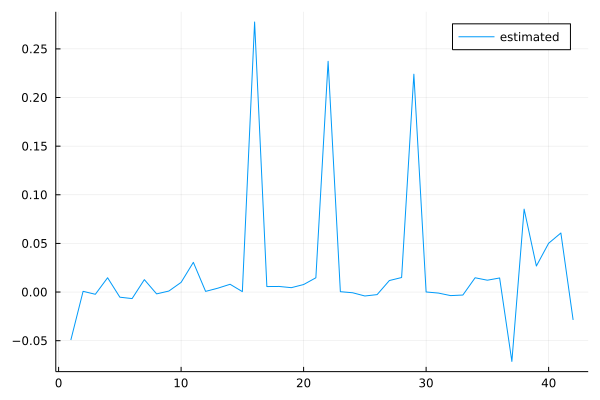

In [60]:
plot(mean(η_), label="estimated")


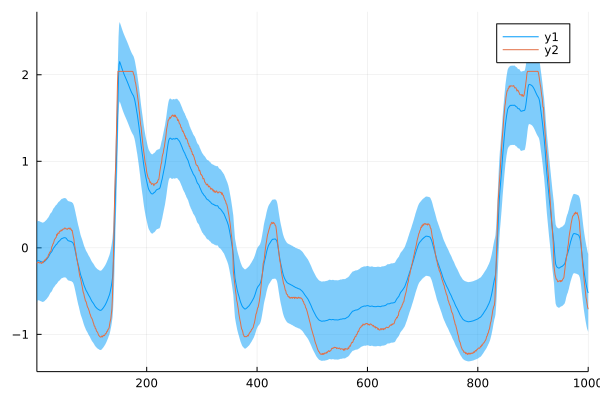

In [61]:
mfrom, mto = 1, 1000
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(mfrom, mto))

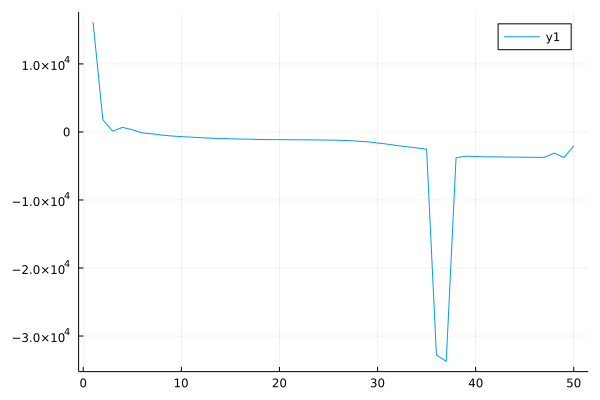

In [62]:
plot(fe_[1:end])

In [63]:
# JLD.save("../dump/narmax_inferred_cascade_$(delay_y)_$(delay_u)_$(delay_e)_$(poly_order).jld", "η_", η_, "τ_", τ_, "w_", w_, "h_", h_, "fe_", fe_)

In [64]:
mean(τ_)

95.35487546181206

In [65]:
mean(w_)

10499.736348452738

In [66]:
mean(η_)

42-element Vector{Float64}:
 -0.04929561486126628
  0.0007494805607952192
 -0.0023013428888769114
  0.014703511418250277
 -0.005284223869552443
 -0.006718853908735988
  0.012761627362620874
 -0.0018846860388324045
  0.001032182826463138
  0.009951596145588338
  0.03054816446007443
  0.0006806244276512616
  0.003981033991090911
  ⋮
 -0.0010388744699442681
 -0.003654203429732924
 -0.0030695171249537005
  0.01467719867519999
  0.012175489317601838
  0.014468864195294412
 -0.07132811696511253
  0.08525146713001601
  0.02675066219135361
  0.050149724753214095
  0.06072218053154452
 -0.02867099773057714

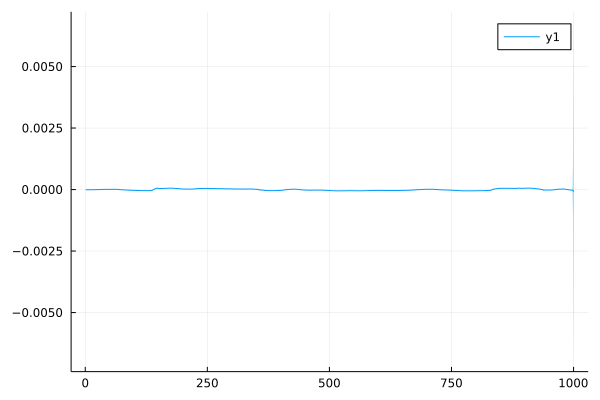

In [67]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))

## Prediction 

In [68]:
function transition(γ, order)
    V = zeros(order, order)
#     V = diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [69]:
function prediction(h_prior, w_mle, η_posterior, τ_posterior, y_prev, u; full_order, h_order)
    h_out = @call_rule MvNormalMeanCovariance(:out, Marginalisation) (m_μ=MvNormalMeanPrecision(mean(h_prior), precision(h_prior)), q_Σ=PointMass(transition(mean(w_), order_h)))
    ϕ_out = @call_rule NonlinearNode(:out, Marginalisation) (m_in=h_out, meta=NonlinearMeta(phi_, y_prev, u, 42))
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=ϕ_out, q_θ=η_posterior, q_γ=τ_posterior, meta=ARMeta(Multivariate, full_order, ARsafe()))
    c = zeros(full_order); c[1] = 1.0
    dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())
    c = zeros(h_order); c[1] = 1.0
    c_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=h_out, meta=ReactiveMP.TinyCorrection())
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=dot_out, m_in2=c_out)    
end

prediction (generic function with 1 method)

In [70]:
τ_ = GammaShapeRate(shape(τ_), rate(τ_))

GammaShapeRate{Float64}(a=600.0, b=6.292284448950798)

In [71]:
predictions = []
h_prior = h_[end]
w_prior = w_
τ_prior = τ_
ProgressMeter.@showprogress for i in 1:length(Y_test)
    pred = prediction(h_prior, mean(w_), η_, τ_, X_test[i], U_test[i], full_order=full_order, h_order=order_h)
    push!(predictions, pred)
    fe_, h_post, θ_post, w_post, η_post, τ_post, _, _ = narmax_inference([Y_test[i]], [X_test[i]], [U_test[i]], h_order=order_h, full_order=full_order,
                                                                         h_prior=(mean(h_prior), precision(h_prior)),
                                                                         w_prior=(shape(w_prior), rate(w_prior)), 
                                                                         η_prior=(mean(η_), precision(η_)),
                                                                         τ_prior=(shape(τ_prior), rate(τ_prior)), vmp_its=10, seed=10, progress=false);
    h_prior = h_post[end]
#     η_prior = η_post
#     τ_prior = τ_post
#     w_prior = w_post
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


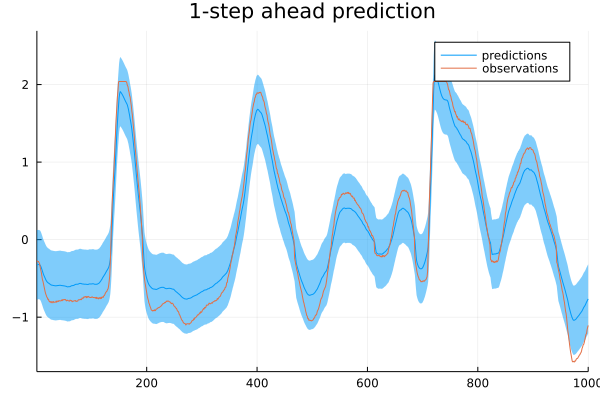

In [72]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))), label="predictions")
plot!(Y_test, xlims=(1, 1000), title="1-step ahead prediction", label="observations")

In [73]:
RMSE = sqrt(mean((mean.(predictions) .- Y_test) .^2))

0.2148613330543241

In [74]:
# naive simulation setting

In [75]:
h_prior = h_[end]
w_prior = w_
τ_prior = τ_
η_prior = η_

simulated_mean = -0.3ones(length(X_test))
simulated_var = ones(length(X_test))
ProgressMeter.@showprogress for i in delay_y:length(Y_test)
    pred_sim = prediction(h_prior, mean(w_), η_prior, τ_, simulated_mean[i-delay_y+1:i], U_test[i], full_order=full_order, h_order=order_h)
    simulated_mean[i] = mean(pred_sim)
    simulated_var[i]  = cov(pred_sim)
    
     _, h_post, θ_post, w_post, η_post, τ_post, _ = narmax_inference([Y_test[i]], [X_test[i]], [U_test[i]], h_order=order_h, full_order=full_order,
                                                                         h_prior=(mean(h_prior), precision(h_prior)),
                                                                         w_prior=(shape(w_prior), rate(w_prior)), 
                                                                         η_prior=(mean(η_), precision(η_)),
                                                                         τ_prior=(shape(τ_prior), rate(τ_prior)), vmp_its=10, seed=10, progress=false);
    h_prior = h_post[end]
#     η_prior = η_post
#     τ_prior = τ_post
#     w_prior = w_post
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


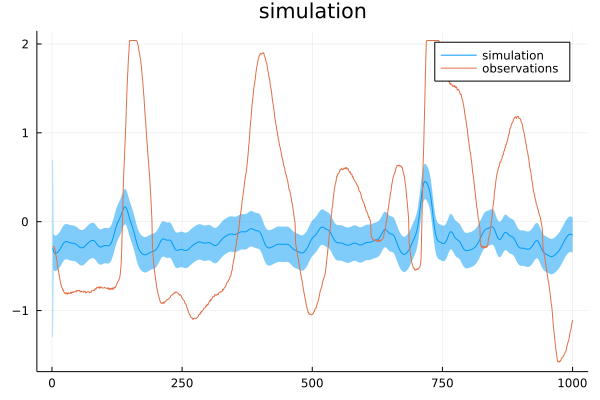

In [76]:
from, to = 1, 1000
plot(simulated_mean[from:to],  ribbon=simulated_var[from:to], label="simulation")
# plot!(first.(U_test[from:to]), label="controls")
plot!(Y_test[from:to], title="simulation", label="observations")

In [77]:
RMSE = sqrt(mean((simulated_mean[from:to] .- Y_test[from:to]).^2))

0.9921025501431312